<a href="https://colab.research.google.com/github/Saoudyahya/switchTransformer/blob/main/trainingTransformersandswitchtransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import numpy as np

class TransformerVisualizer:
    def __init__(self, model_name="bert-base-uncased"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()  # Set to evaluation mode

    def get_neuron_activations(self, text, layer_idx=0):
        """Get neuron activations for a given text and layer."""
        inputs = self.tokenizer(text, return_tensors="pt", add_special_tokens=True)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        activations = {}

        def hook_fn(module, input, output):
            # Store the hidden states (output[0]) from the transformer layer
            activations['layer_output'] = output[0].detach()

        # Register hook on the specified transformer layer
        hook = self.model.encoder.layer[layer_idx].register_forward_hook(hook_fn)

        with torch.no_grad():
            outputs = self.model(**inputs)

        hook.remove()

        return activations, tokens

    def visualize_neuron_features(self, text, top_k=5, layer_idx=0):
        """Visualize neuron activations for the given text."""
        activations, tokens = self.get_neuron_activations(text, layer_idx)
        layer_output = activations['layer_output'].squeeze(0)

        # Create figure with specific size ratio and spacing
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.3)

        # Plot 1: Neuron Activation Heatmap
        ax1 = fig.add_subplot(gs[0])
        sns.heatmap(layer_output[:, :min(50, layer_output.shape[1])].numpy(),
                   cmap='viridis',
                   xticklabels=False,
                   yticklabels=tokens,
                   ax=ax1)
        ax1.set_title(f'Layer {layer_idx} Neuron Activations (First 50 Neurons)')
        ax1.set_xlabel('Neuron Index')
        ax1.set_ylabel('Tokens')

        # Plot 2: Top Neurons Activity
        ax2 = fig.add_subplot(gs[1])
        neuron_importance = layer_output.abs().mean(dim=0)
        top_neurons = torch.topk(neuron_importance, min(top_k, neuron_importance.size(0)))

        x = np.arange(len(tokens))
        for i, neuron_idx in enumerate(top_neurons.indices):
            ax2.plot(x, layer_output[:, neuron_idx].numpy(),
                    marker='o',
                    label=f'Neuron {neuron_idx}',
                    linewidth=2,
                    markersize=8)

        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.set_xticks(x)
        ax2.set_xticklabels(tokens, rotation=45, ha='right')
        ax2.set_title(f'Top {top_k} Neurons Activity Patterns')
        ax2.set_xlabel('Tokens')
        ax2.set_ylabel('Activation Value')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

        # Print detailed analysis
        print(f"\nLayer {layer_idx} Feature Analysis:")
        for i, neuron_idx in enumerate(top_neurons.indices):
            activations_for_neuron = layer_output[:, neuron_idx]
            max_token_idx = activations_for_neuron.argmax()
            min_token_idx = activations_for_neuron.argmin()

            print(f"\nNeuron {neuron_idx}:")
            print(f"  Strongest activation: {tokens[max_token_idx]} ({activations_for_neuron[max_token_idx]:.3f})")
            print(f"  Weakest activation: {tokens[min_token_idx]} ({activations_for_neuron[min_token_idx]:.3f})")
            print(f"  Mean activation: {activations_for_neuron.mean():.3f}")
            print(f"  Std deviation: {activations_for_neuron.std():.3f}")

def analyze_transformer_neurons(text, model_name="bert-base-uncased", layer_idx=0):
    """Analyze transformer neuron activations for the given text."""
    visualizer = TransformerVisualizer(model_name)
    visualizer.visualize_neuron_features(text, layer_idx=layer_idx)

# Example usage
if __name__ == "__main__":
    sample_text = "The strategic merger between the two leading tech companies will create a synergy that promises to revolutionize the industry."
    analyze_transformer_neurons(sample_text, layer_idx=0)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path= "/content/cnbc_headlines.csv"
data1=pd.read_csv(path)

path= "/content/guardian_headlines.csv.csv"
data2=pd.read_csv(path)

path= "/content/reuters_headlines.csv.csv"
data3=pd.read_csv(path)


,Headlines,Time,Description
0,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer recommended buying..."
1,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","""Mad Money"" host Jim Cramer rings the lightnin..."
2,NaN,NaN,NaN
3,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","""We'll pay more for the earnings of the non-Co..."
4,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","Keith Bliss, IQ Capital CEO, joins ""Closing Be..."


In [ ]:
data3

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,Jul 18 2020,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,Jul 18 2020,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,Jul 18 2020,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,Jul 18 2020,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,Jul 17 2020,A battle in the U.S. Congress over a new coron...
...,...,...,...
32765,Malaysia says never hired British data firm at...,Mar 20 2018,The Malaysian government and the ruling party ...
32766,Prosecutors search Volkswagen headquarters in ...,Mar 20 2018,German prosecutors said on Tuesday they had se...
32767,McDonald's sets greenhouse gas reduction targets,Mar 20 2018,McDonald's Corp on Tuesday announced an approv...
32768,Pratt & Whitney to deliver spare A320neo engin...,Mar 20 2018,Pratt & Whitney will soon begin deliveries of ...


In [ ]:
import pandas as pd

# Load the datasets
path1 = "/content/cnbc_headlines.csv"
data1 = pd.read_csv(path1)

path2 = "/content/guardian_headlines.csv"
data2 = pd.read_csv(path2)

path3 = "/content/reuters_headlines.csv"
data3 = pd.read_csv(path3)

# Extract the relevant columns ('Description' or 'Headlines')
descriptions1 = data1['Description']  # From CNBC
descriptions2 = data2['Headlines']    # From Guardian
descriptions3 = data3['Description']  # From Reuters

# Combine the descriptions into a single DataFrame
merged_descriptions = pd.concat([descriptions1, descriptions2, descriptions3], axis=0, ignore_index=True)

# Save the new dataset to a CSV file
merged_descriptions.to_csv('/content/merged_descriptions.csv', index=False, header=['description'])

print("Merged dataset saved as 'merged_descriptions.csv'.")


Merged dataset saved as 'merged_descriptions.csv'.


In [ ]:
merged_descriptions

,0
0,"""Mad Money"" host Jim Cramer recommended buying..."
1,"""Mad Money"" host Jim Cramer rings the lightnin..."
2,NaN
3,"""We'll pay more for the earnings of the non-Co..."
4,"Keith Bliss, IQ Capital CEO, joins ""Closing Be..."
...,...
53645,The Malaysian government and the ruling party ...
53646,German prosecutors said on Tuesday they had se...
53647,McDonald's Corp on Tuesday announced an approv...
53648,Pratt & Whitney will soon begin deliveries of ...



Analyzing Sample 1: Tesla Inc on Wednesday became the highest-valued automaker as its shares surged to record highs and the electric carmaker's market capitalization overtook that of former front runner Toyota Motors Corp.



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<ipython-input-5-a24ff93675a6>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


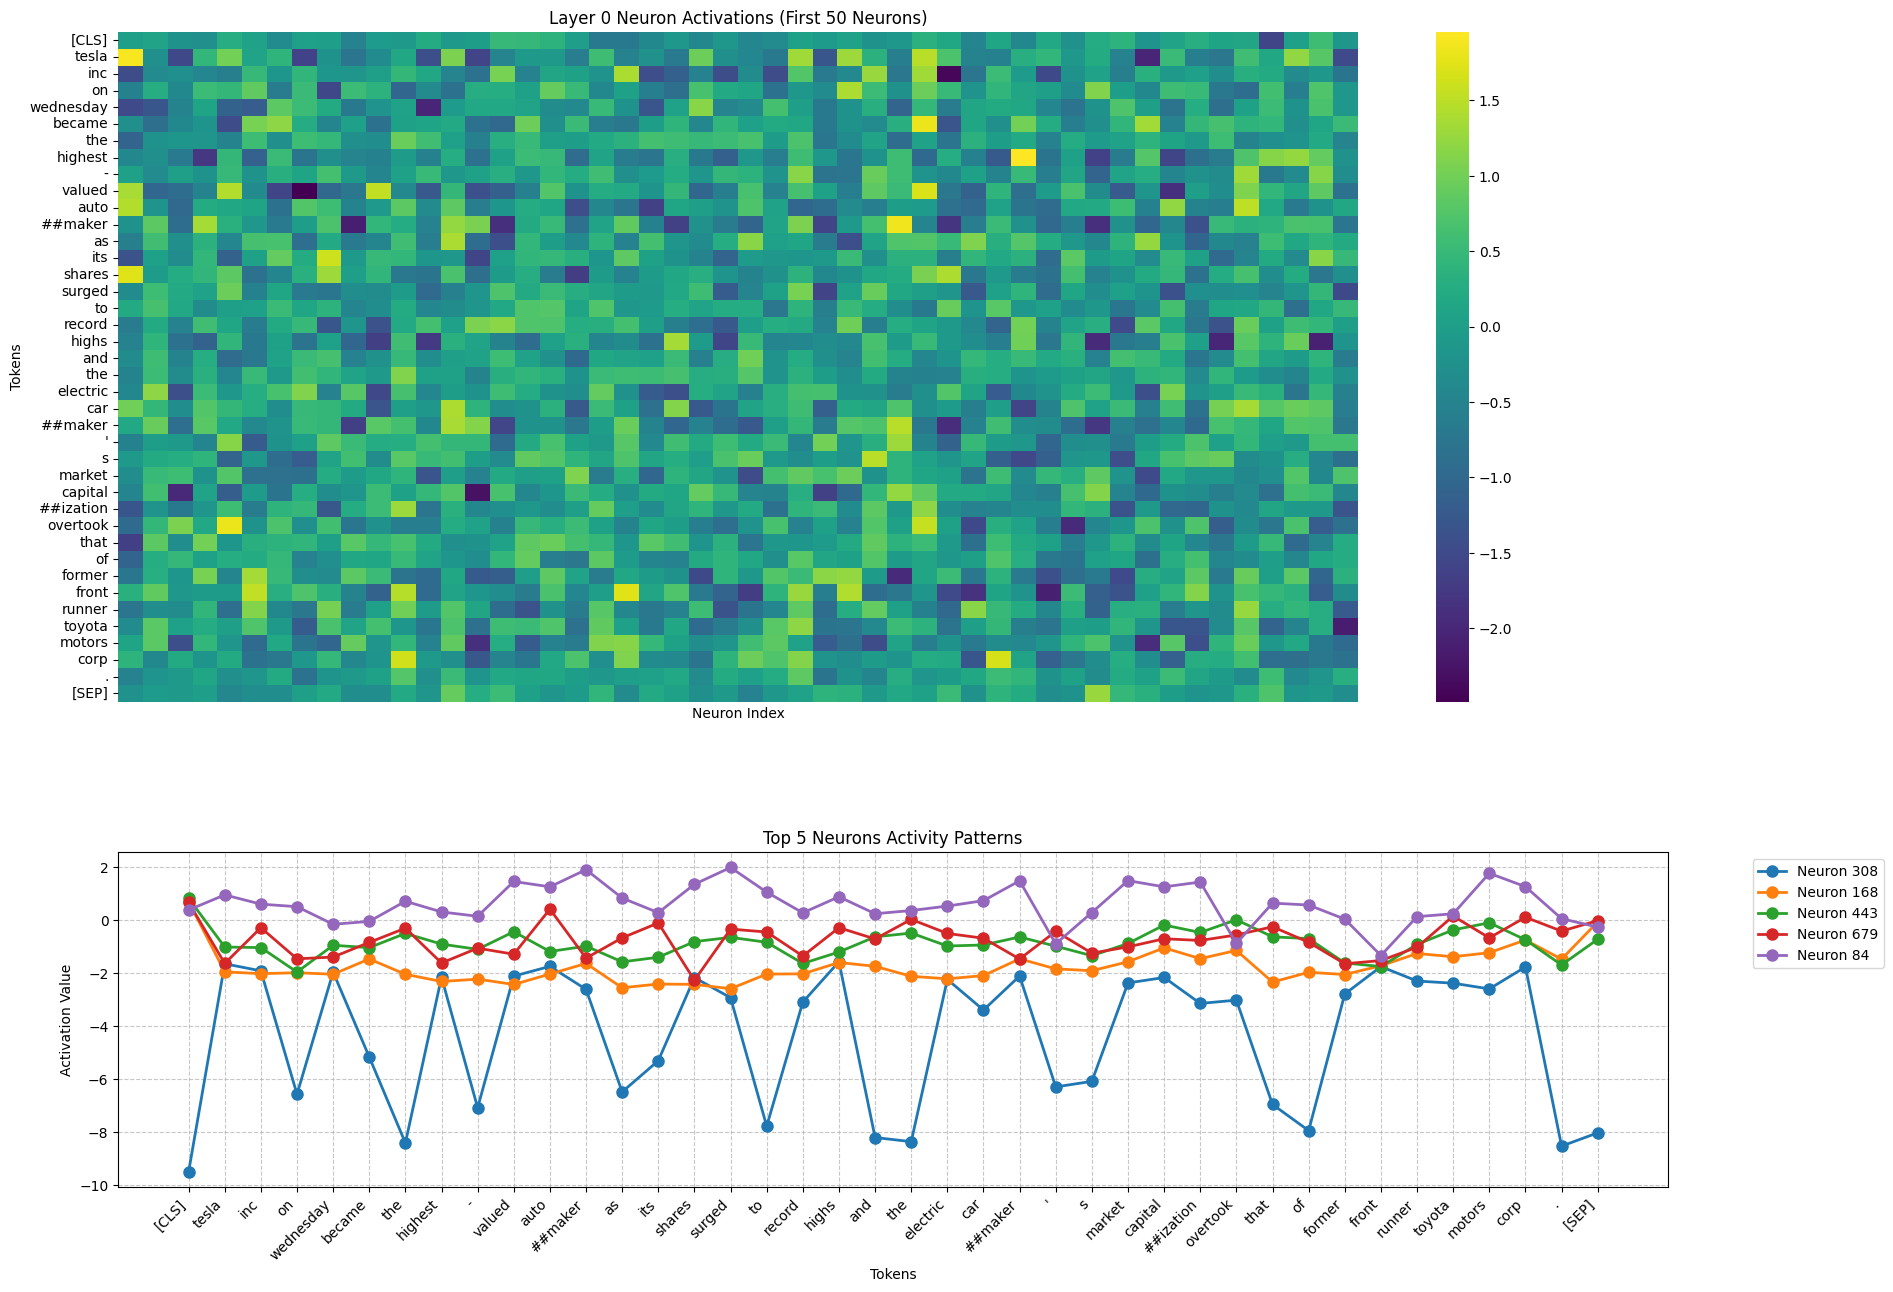


Layer 0 Feature Analysis:

Neuron 308:
  Strongest activation: highs (-1.572)
  Weakest activation: [CLS] (-9.493)
  Mean activation: -4.316
  Std deviation: 2.607

Neuron 168:
  Strongest activation: [CLS] (0.692)
  Weakest activation: surged (-2.591)
  Mean activation: -1.752
  Std deviation: 0.651

Neuron 443:
  Strongest activation: [CLS] (0.812)
  Weakest activation: on (-1.962)
  Mean activation: -0.884
  Std deviation: 0.531

Neuron 679:
  Strongest activation: [CLS] (0.662)
  Weakest activation: shares (-2.274)
  Mean activation: -0.752
  Std deviation: 0.645

Neuron 84:
  Strongest activation: surged (1.978)
  Weakest activation: front (-1.340)
  Mean activation: 0.590
  Std deviation: 0.752

Analyzing Sample 2: Observer business agenda  Disney’s stable of heroes dominates the big-screen galaxy



<ipython-input-5-a24ff93675a6>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


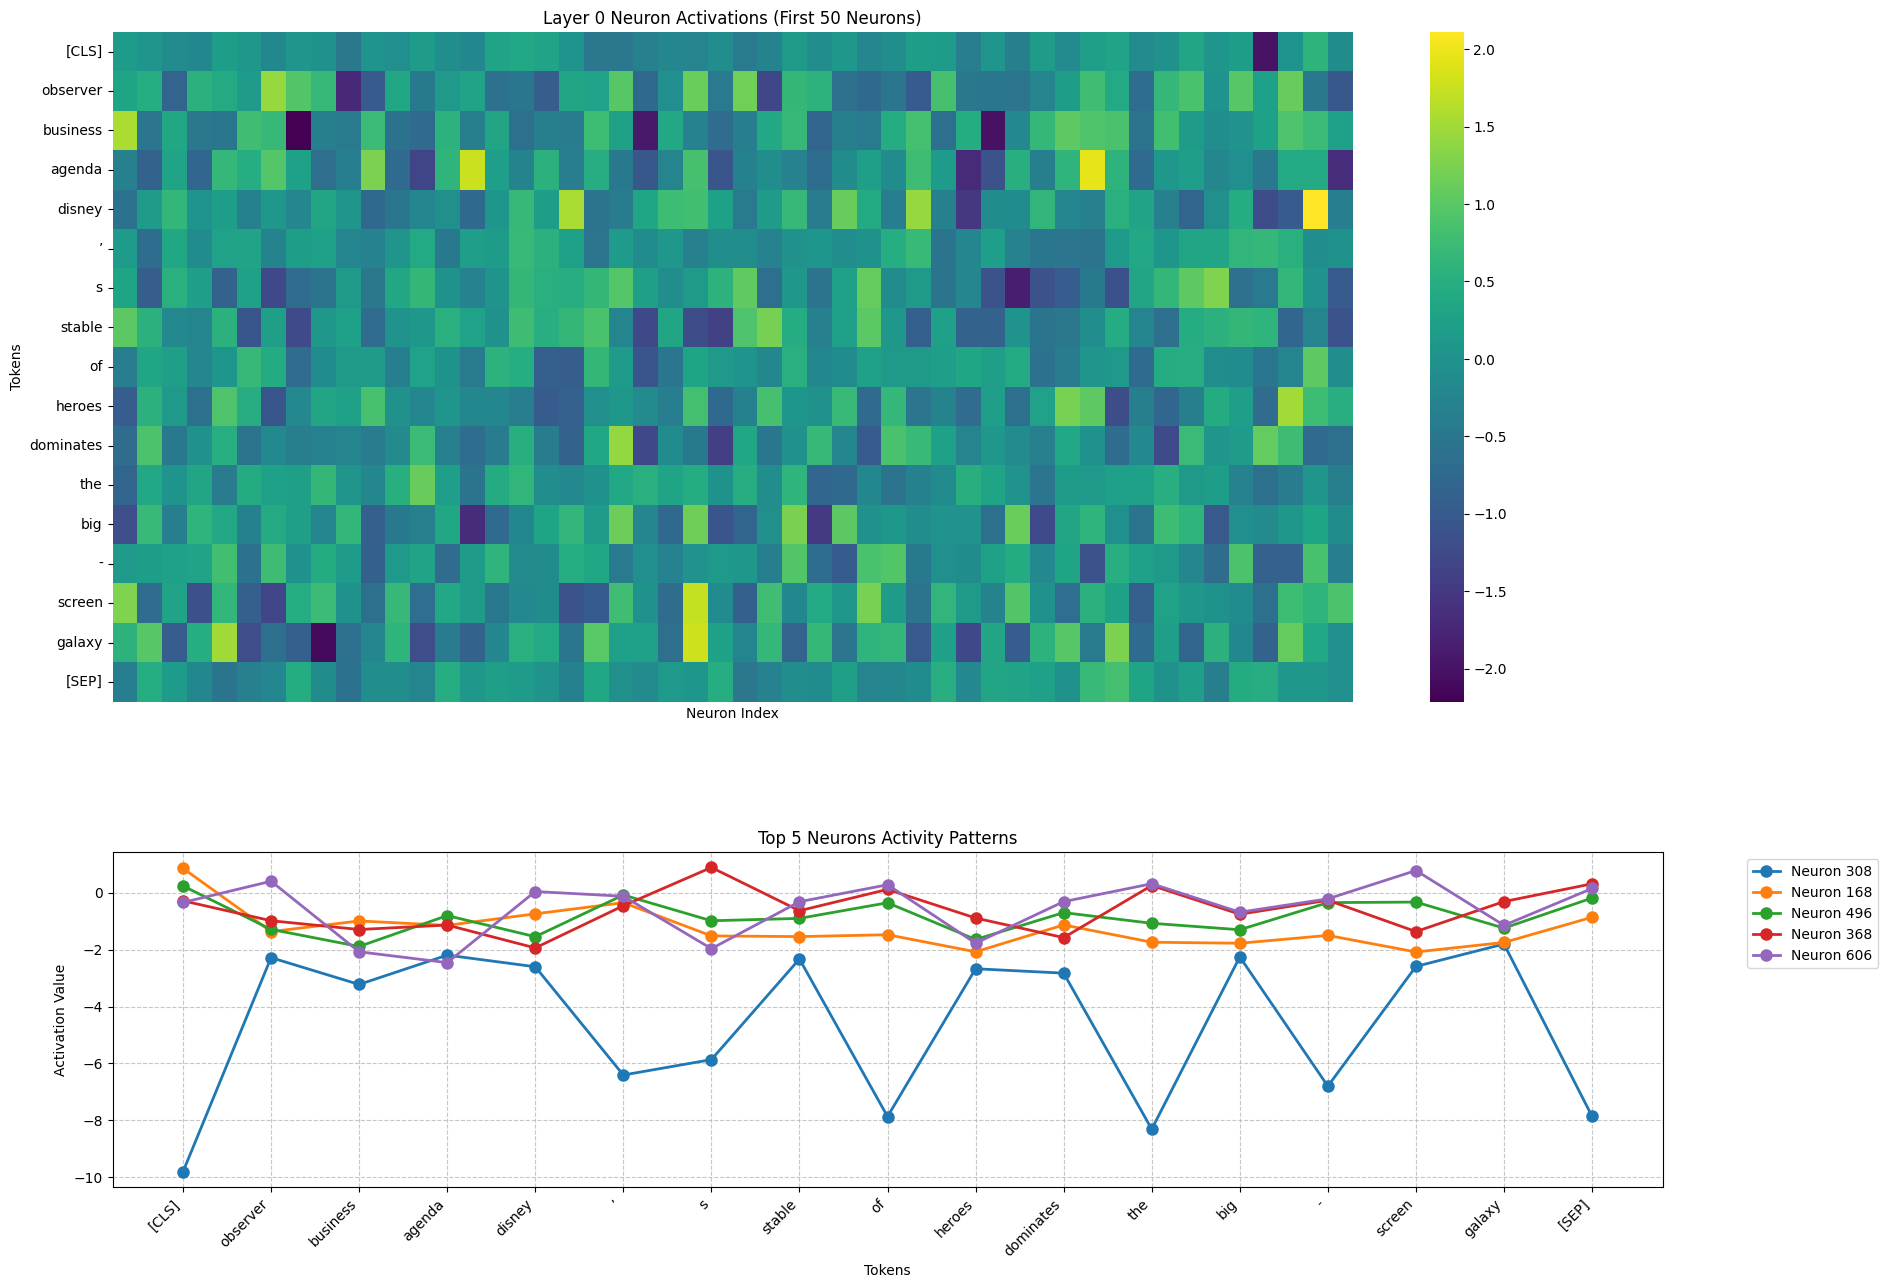


Layer 0 Feature Analysis:

Neuron 308:
  Strongest activation: galaxy (-1.805)
  Weakest activation: [CLS] (-9.804)
  Mean activation: -4.570
  Std deviation: 2.717

Neuron 168:
  Strongest activation: [CLS] (0.854)
  Weakest activation: screen (-2.085)
  Mean activation: -1.249
  Std deviation: 0.714

Neuron 496:
  Strongest activation: [CLS] (0.234)
  Weakest activation: business (-1.891)
  Mean activation: -0.852
  Std deviation: 0.603

Neuron 368:
  Strongest activation: s (0.884)
  Weakest activation: disney (-1.942)
  Mean activation: -0.610
  Std deviation: 0.748

Neuron 606:
  Strongest activation: screen (0.776)
  Weakest activation: agenda (-2.459)
  Mean activation: -0.558
  Std deviation: 0.975

Analyzing Sample 3: The German government on Wednesday welcomed Tesla's decision to set up shop in Berlin, a move it believes will turbo-charge the country's shift into the electric car era even as costs of running a business in Europe's largest economy remain high.



<ipython-input-5-a24ff93675a6>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


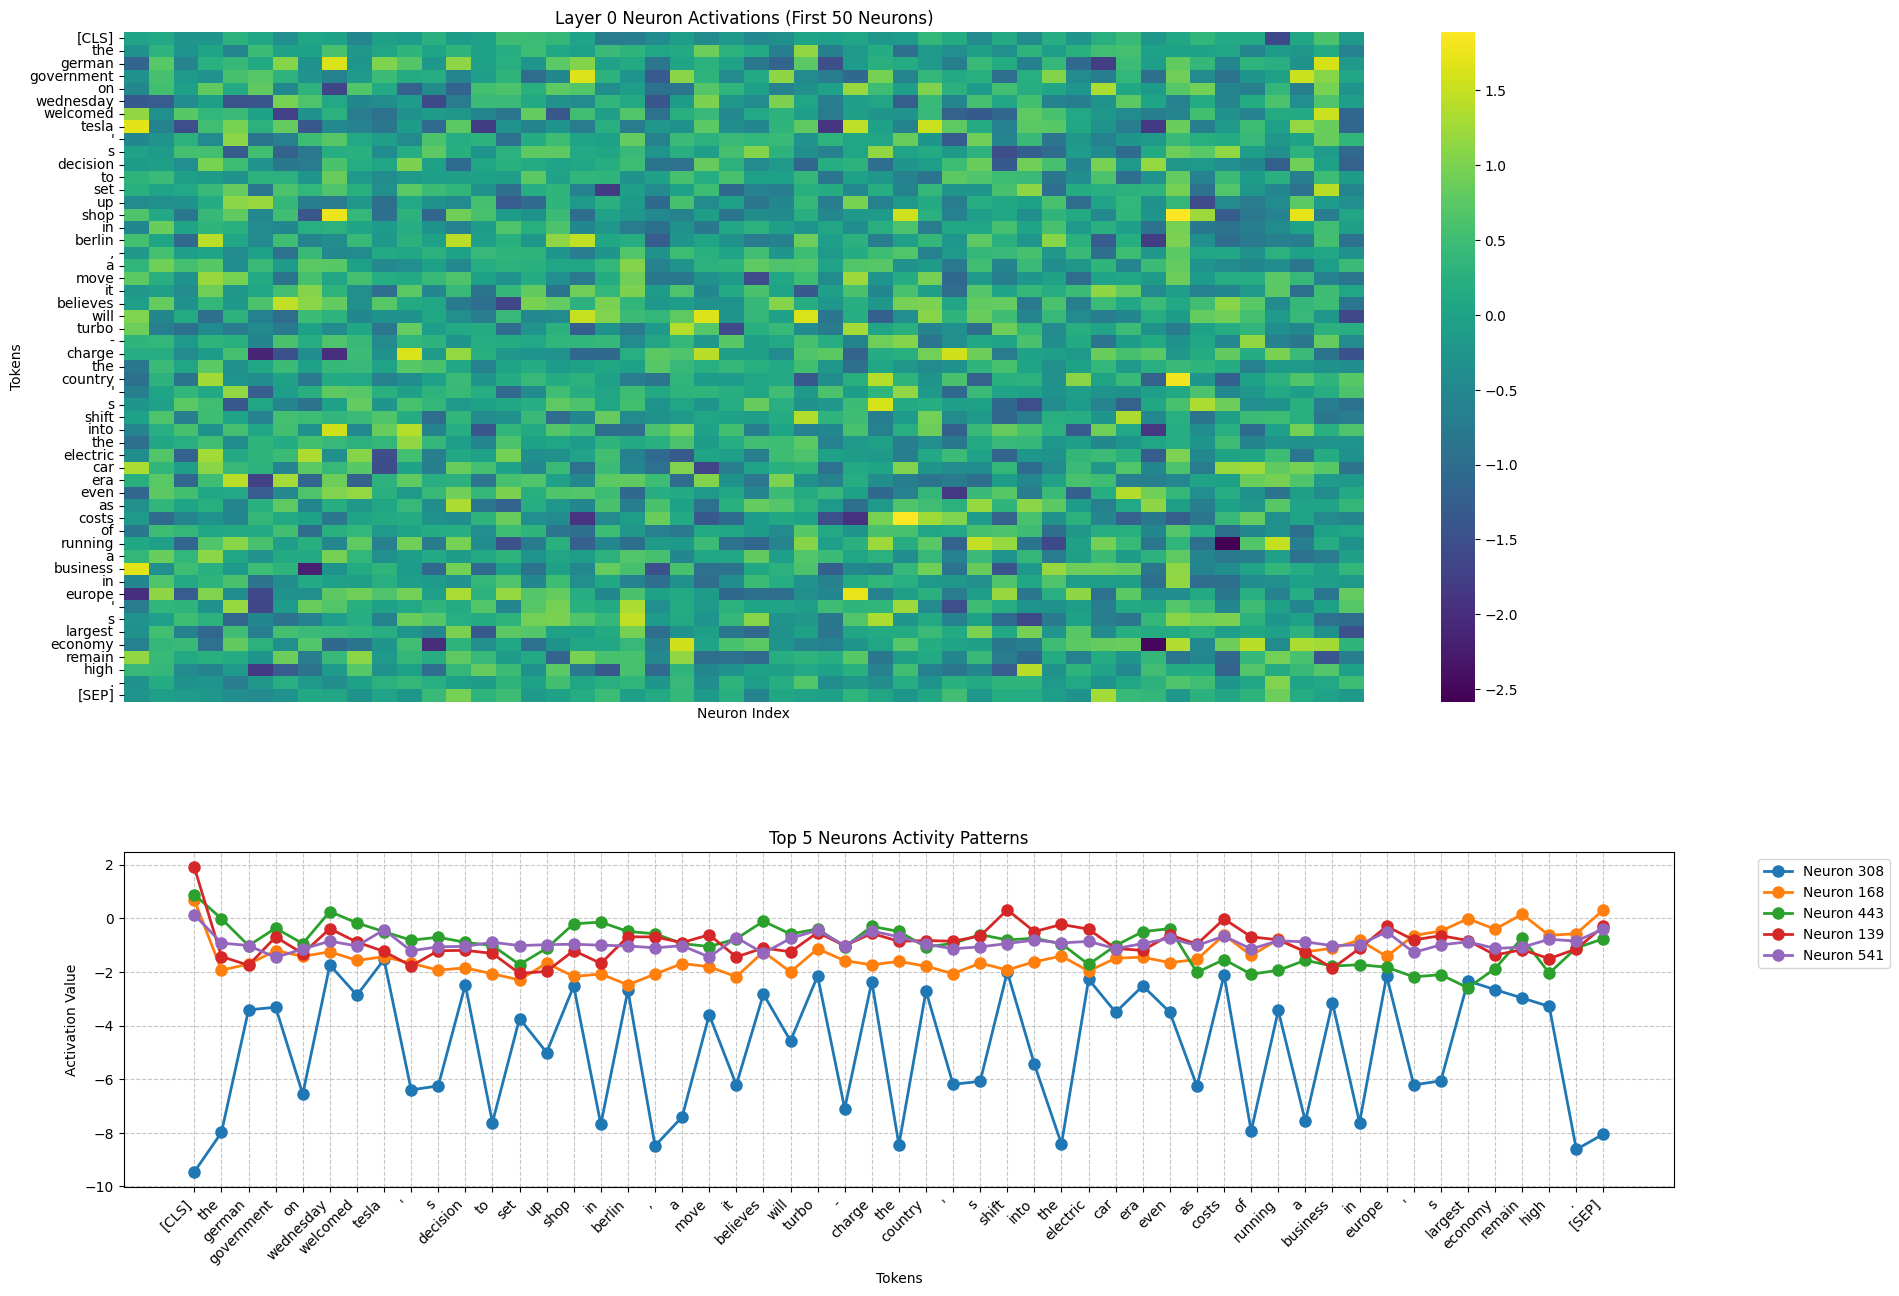


Layer 0 Feature Analysis:

Neuron 308:
  Strongest activation: tesla (-1.539)
  Weakest activation: [CLS] (-9.453)
  Mean activation: -4.861
  Std deviation: 2.380

Neuron 168:
  Strongest activation: [CLS] (0.683)
  Weakest activation: berlin (-2.485)
  Mean activation: -1.387
  Std deviation: 0.689

Neuron 443:
  Strongest activation: [CLS] (0.881)
  Weakest activation: largest (-2.597)
  Mean activation: -0.982
  Std deviation: 0.709

Neuron 139:
  Strongest activation: [CLS] (1.894)
  Weakest activation: set (-2.060)
  Mean activation: -0.923
  Std deviation: 0.630

Neuron 541:
  Strongest activation: [CLS] (0.130)
  Weakest activation: government (-1.460)
  Mean activation: -0.924
  Std deviation: 0.273

Analyzing Sample 4: UK and Ireland retailers warn of 40% tariffs on food in no-deal Brexit



<ipython-input-5-a24ff93675a6>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


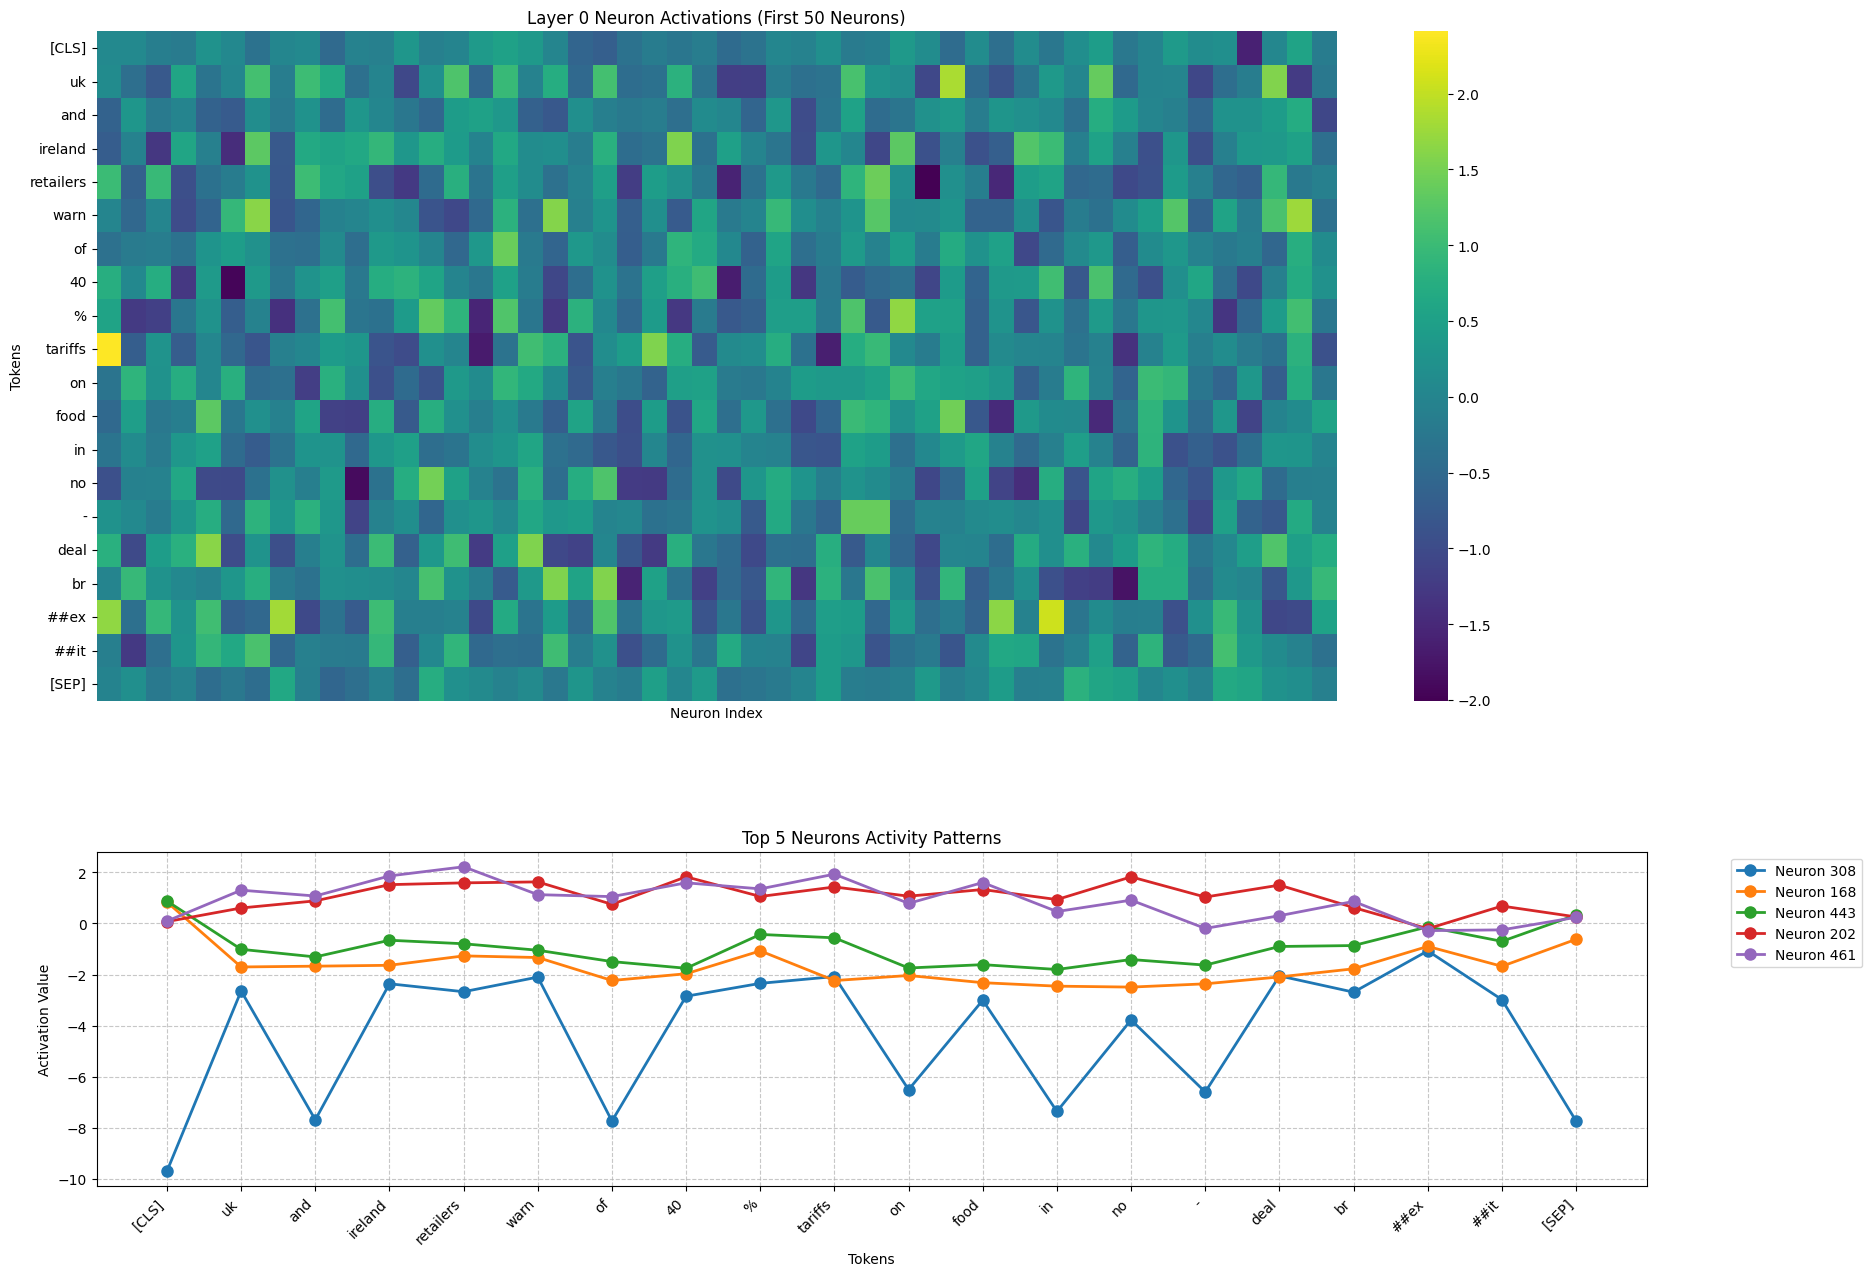


Layer 0 Feature Analysis:

Neuron 308:
  Strongest activation: ##ex (-1.074)
  Weakest activation: [CLS] (-9.700)
  Mean activation: -4.299
  Std deviation: 2.620

Neuron 168:
  Strongest activation: [CLS] (0.836)
  Weakest activation: no (-2.493)
  Mean activation: -1.653
  Std deviation: 0.790

Neuron 443:
  Strongest activation: [CLS] (0.876)
  Weakest activation: in (-1.803)
  Mean activation: -0.934
  Std deviation: 0.719

Neuron 202:
  Strongest activation: 40 (1.826)
  Weakest activation: ##ex (-0.207)
  Mean activation: 1.020
  Std deviation: 0.574

Neuron 461:
  Strongest activation: retailers (2.219)
  Weakest activation: ##ex (-0.282)
  Mean activation: 0.902
  Std deviation: 0.752

Analyzing Sample 5: Ovo to be UK's second-largest energy supplier after £500m SSE deal



<ipython-input-5-a24ff93675a6>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


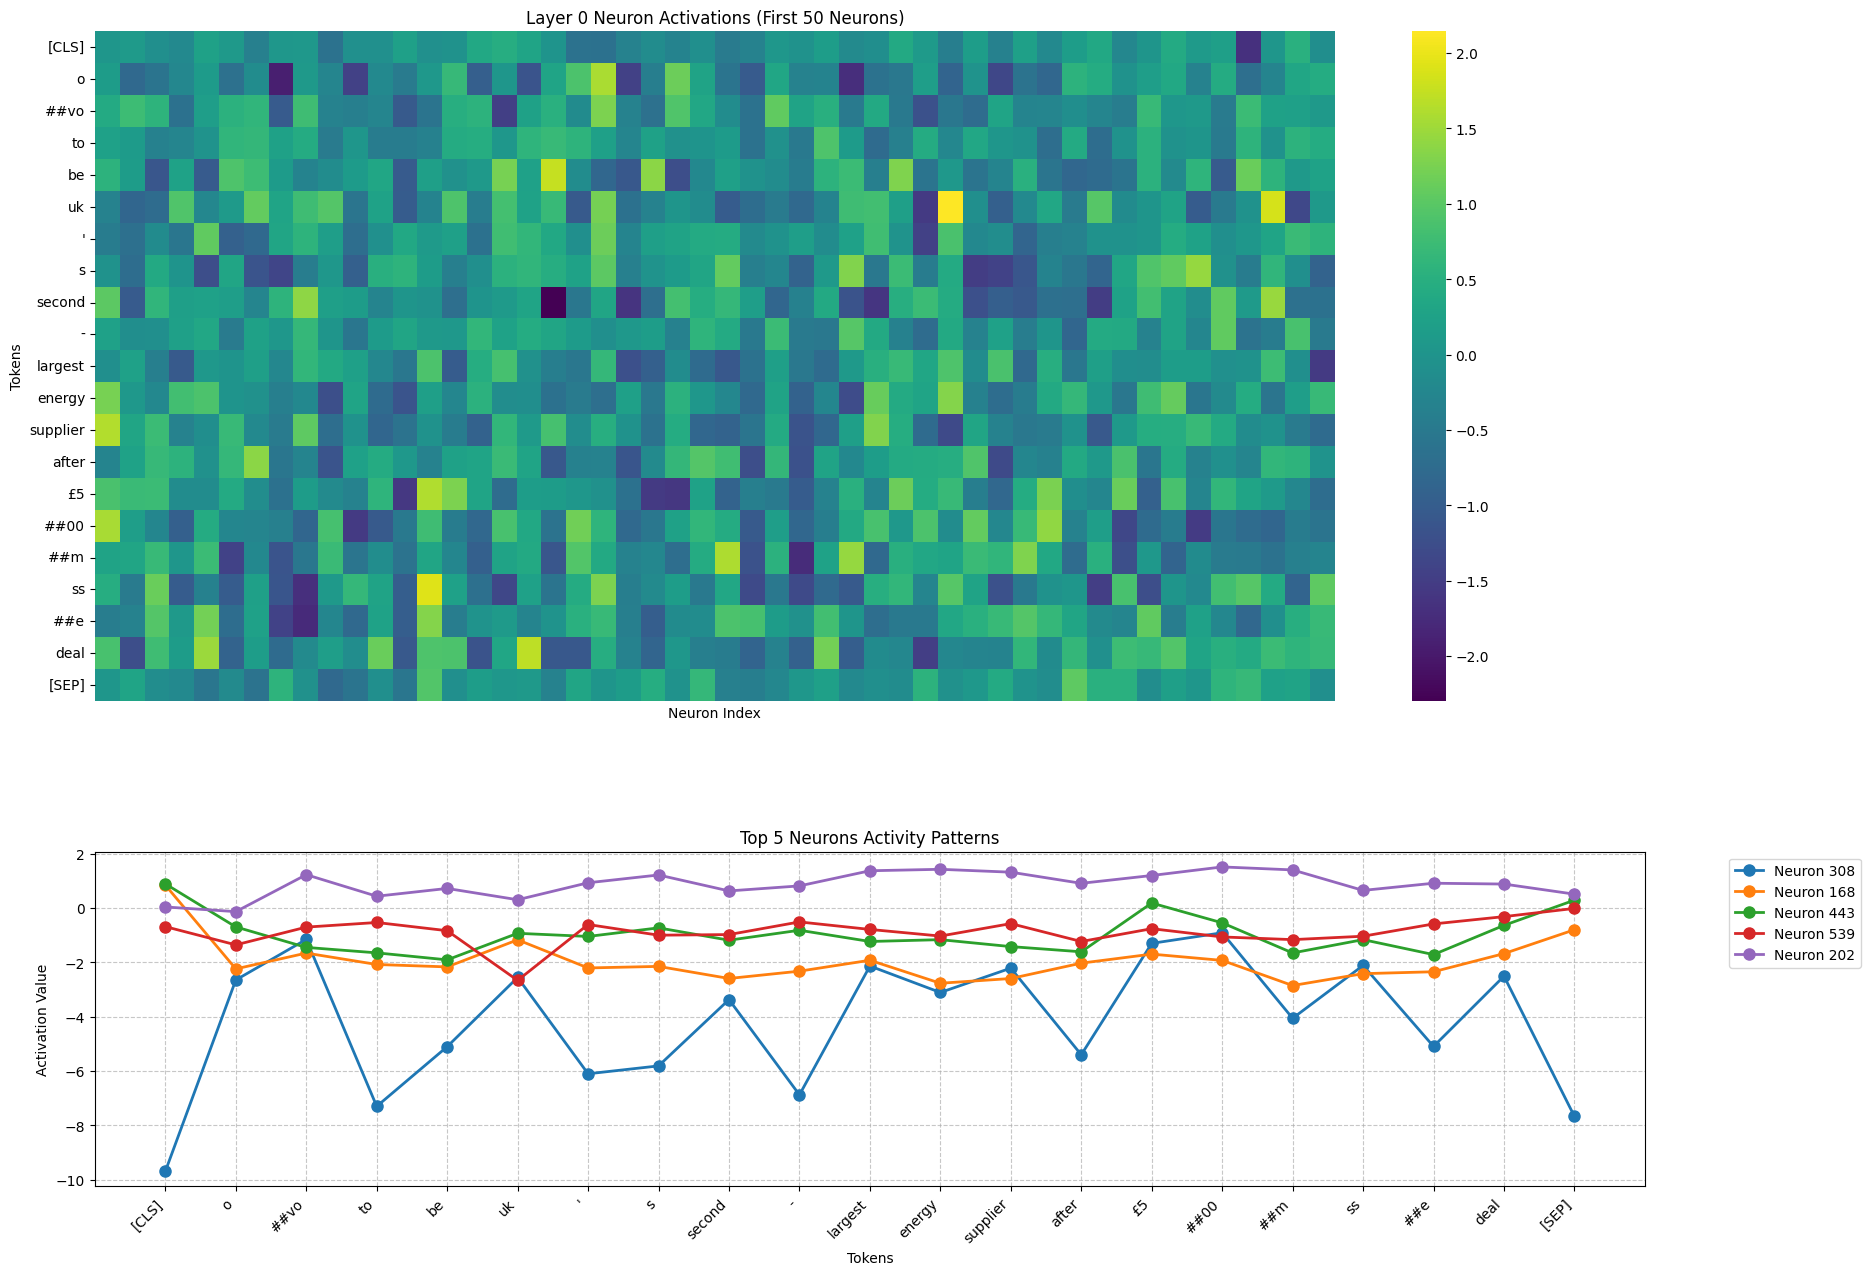


Layer 0 Feature Analysis:

Neuron 308:
  Strongest activation: ##00 (-0.913)
  Weakest activation: [CLS] (-9.691)
  Mean activation: -4.151
  Std deviation: 2.440

Neuron 168:
  Strongest activation: [CLS] (0.839)
  Weakest activation: ##m (-2.855)
  Mean activation: -1.944
  Std deviation: 0.807

Neuron 443:
  Strongest activation: [CLS] (0.886)
  Weakest activation: be (-1.910)
  Mean activation: -0.964
  Std deviation: 0.715

Neuron 539:
  Strongest activation: [SEP] (-0.016)
  Weakest activation: uk (-2.666)
  Mean activation: -0.881
  Std deviation: 0.519

Neuron 202:
  Strongest activation: ##00 (1.510)
  Weakest activation: o (-0.136)
  Mean activation: 0.867
  Std deviation: 0.463


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import numpy as np

# Load the merged dataset
data_path = "/content/merged_descriptions.csv"
data = pd.read_csv(data_path)

# Preprocess: Drop NaN values and select a few sample texts
data = data.dropna()
sample_texts = data['description'].sample(5).tolist()  # Select 5 random descriptions

class TransformerVisualizer:
    def __init__(self, model_name="bert-base-uncased"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()  # Set to evaluation mode

    def get_neuron_activations(self, text, layer_idx=0):
        """Get neuron activations for a given text and layer."""
        inputs = self.tokenizer(text, return_tensors="pt", add_special_tokens=True)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        activations = {}

        def hook_fn(module, input, output):
            # Store the hidden states (output[0]) from the transformer layer
            activations['layer_output'] = output[0].detach()

        # Register hook on the specified transformer layer
        hook = self.model.encoder.layer[layer_idx].register_forward_hook(hook_fn)

        with torch.no_grad():
            outputs = self.model(**inputs)

        hook.remove()

        return activations, tokens

    def visualize_neuron_features(self, text, top_k=5, layer_idx=0):
        """Visualize neuron activations for the given text."""
        activations, tokens = self.get_neuron_activations(text, layer_idx)
        layer_output = activations['layer_output'].squeeze(0)

        # Create figure with specific size ratio and spacing
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.3)

        # Plot 1: Neuron Activation Heatmap
        ax1 = fig.add_subplot(gs[0])
        sns.heatmap(layer_output[:, :min(50, layer_output.shape[1])].numpy(),
                   cmap='viridis',
                   xticklabels=False,
                   yticklabels=tokens,
                   ax=ax1)
        ax1.set_title(f'Layer {layer_idx} Neuron Activations (First 50 Neurons)')
        ax1.set_xlabel('Neuron Index')
        ax1.set_ylabel('Tokens')

        # Plot 2: Top Neurons Activity
        ax2 = fig.add_subplot(gs[1])
        neuron_importance = layer_output.abs().mean(dim=0)
        top_neurons = torch.topk(neuron_importance, min(top_k, neuron_importance.size(0)))

        x = np.arange(len(tokens))
        for i, neuron_idx in enumerate(top_neurons.indices):
            ax2.plot(x, layer_output[:, neuron_idx].numpy(),
                    marker='o',
                    label=f'Neuron {neuron_idx}',
                    linewidth=2,
                    markersize=8)

        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.set_xticks(x)
        ax2.set_xticklabels(tokens, rotation=45, ha='right')
        ax2.set_title(f'Top {top_k} Neurons Activity Patterns')
        ax2.set_xlabel('Tokens')
        ax2.set_ylabel('Activation Value')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

        # Print detailed analysis
        print(f"\nLayer {layer_idx} Feature Analysis:")
        for i, neuron_idx in enumerate(top_neurons.indices):
            activations_for_neuron = layer_output[:, neuron_idx]
            max_token_idx = activations_for_neuron.argmax()
            min_token_idx = activations_for_neuron.argmin()

            print(f"\nNeuron {neuron_idx}:")
            print(f"  Strongest activation: {tokens[max_token_idx]} ({activations_for_neuron[max_token_idx]:.3f})")
            print(f"  Weakest activation: {tokens[min_token_idx]} ({activations_for_neuron[min_token_idx]:.3f})")
            print(f"  Mean activation: {activations_for_neuron.mean():.3f}")
            print(f"  Std deviation: {activations_for_neuron.std():.3f}")

def analyze_transformer_neurons(text, model_name="bert-base-uncased", layer_idx=0):
    """Analyze transformer neuron activations for the given text."""
    visualizer = TransformerVisualizer(model_name)
    visualizer.visualize_neuron_features(text, layer_idx=layer_idx)

# Analyze and visualize neuron activations for sample texts
for i, text in enumerate(sample_texts):
    print(f"\nAnalyzing Sample {i + 1}: {text}\n")
    analyze_transformer_neurons(text, layer_idx=0)


In [ ]:
# Replace the _preprocess_data method in the previous artifact
def _preprocess_data(self):
    # Clean and convert descriptions to list
    descriptions = self.merged_descriptions[0].dropna().values.tolist()

    tokenized_inputs = self.tokenizer(
        descriptions,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Simple dummy task: predict text length category
    def categorize_length(text):
        length = len(text.split())
        if length < 10: return 0
        elif length < 20: return 1
        else: return 2

    labels = torch.tensor([categorize_length(desc) for desc in descriptions])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        tokenized_inputs['input_ids'],
        labels,
        test_size=0.2,
        random_state=42
    )

    return X_train, X_test, y_train, y_test

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SwitchTransformer(nn.Module):
    def __init__(self, vocab_size, input_dim, num_experts, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, input_dim)

        # Layer configuration
        self.layers = nn.ModuleList([
            SwitchTransformerLayer(input_dim, num_experts, hidden_dim)
            for _ in range(num_layers)
        ])

        # Classification head
        self.classifier = nn.Linear(input_dim, 3)  # 3 categories of text length

    def forward(self, input_ids):
        # Embedding
        x = self.embedding(input_ids)

        # Store gate scores for each layer
        all_gate_scores = []

        # Process through layers
        for layer in self.layers:
            x, gate_scores = layer(x)
            all_gate_scores.append(gate_scores)

        # Classification
        logits = self.classifier(x.mean(dim=1))

        return logits, all_gate_scores

class SwitchTransformerLayer(nn.Module):
    def __init__(self, input_dim, num_experts, hidden_dim):
        super().__init__()

        # Expert network
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, input_dim)
            ) for _ in range(num_experts)
        ])

        # Gate network
        self.gate = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        # Calculate gate scores
        gate_scores = F.softmax(self.gate(x), dim=-1)

        # Expert routing
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)

        # Weighted combination of expert outputs
        output = torch.einsum('bse,bsn->bne', expert_outputs, gate_scores)

        return output, gate_scores

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split



class SwitchTransformerTrainer:
    def __init__(self, model_configs, merged_descriptions):
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.vocab_size = self.tokenizer.vocab_size
        self.model_configs = model_configs
        self.merged_descriptions = merged_descriptions
        self.models = self._initialize_models()

    def _initialize_models(self):
        models = []
        for config in self.model_configs:
            model = SwitchTransformer(
                self.vocab_size,
                config['input_dim'],
                config['num_experts'],
                config['hidden_dim'],
                config['num_layers']
            )
            model_name = f"Model_{config['input_dim']}d_{config['num_experts']}e_{config['num_layers']}l"
            models.append((model_name, model))
        return models

    def _preprocess_data(self):
        # Check DataFrame structure
        print(self.merged_descriptions.columns)

        # Use the first column of the DataFrame
        descriptions = self.merged_descriptions.iloc[:, 0].dropna().tolist()

        tokenized_inputs = self.tokenizer(
            descriptions,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        # Simple dummy task: predict text length category
        def categorize_length(text):
            length = len(str(text).split())
            if length < 10: return 0
            elif length < 20: return 1
            else: return 2

        labels = torch.tensor([categorize_length(desc) for desc in descriptions])

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            tokenized_inputs['input_ids'],
            labels,
            test_size=0.2,
            random_state=42
        )

        return X_train, X_test, y_train, y_test

    def train_models(self, epochs=5, lr=0.001):
        X_train, X_test, y_train, y_test = self._preprocess_data()

        trained_models = []
        training_histories = {}

        for model_name, model in self.models:
            # Loss and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Tracking metrics
            model_history = {
                'train_loss': [],
                'test_loss': [],
                'accuracy': []
            }

            # Training loop
            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                # Forward pass
                outputs, _ = model(X_train)
                loss = criterion(outputs, y_train)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Validation
                model.eval()
                with torch.no_grad():
                    test_outputs, _ = model(X_test)
                    test_loss = criterion(test_outputs, y_test)
                    accuracy = (test_outputs.argmax(1) == y_test).float().mean()

                # Store metrics
                model_history['train_loss'].append(loss.item())
                model_history['test_loss'].append(test_loss.item())
                model_history['accuracy'].append(accuracy.item())

                print(f"{model_name} - Epoch {epoch+1}: Train Loss {loss.item():.4f}, "
                      f"Test Loss {test_loss.item():.4f}, Accuracy {accuracy.item():.4f}")

            trained_models.append((model_name, model))
            training_histories[model_name] = model_history

        self._plot_training_metrics(training_histories)
        return trained_models

    def _plot_training_metrics(self, training_histories):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        # Plot training loss
        ax1.set_title('Training Loss')
        for model_name, history in training_histories.items():
            ax1.plot(history['train_loss'], label=model_name)
        ax1.legend()

        # Plot test loss
        ax2.set_title('Test Loss')
        for model_name, history in training_histories.items():
            ax2.plot(history['test_loss'], label=model_name)
        ax2.legend()

        # Plot accuracy
        ax3.set_title('Accuracy')
        for model_name, history in training_histories.items():
            ax3.plot(history['accuracy'], label=model_name)
        ax3.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
import sys
sys.path.append('.')


import pandas as pd

def main():
    model_configs = [
        {
            'input_dim': 64,
            'num_experts': 4,
            'hidden_dim': 128,
            'num_layers': 2
        }
    ]

    # Load your merged descriptions
    merged_descriptions = pd.read_csv('merged_descriptions.csv')  # Adjust path as needed

    trainer = SwitchTransformerTrainer(model_configs, merged_descriptions)
    trained_models = trainer.train_models()

if __name__ == "__main__":
    main()

Index(['description'], dtype='object')


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM, AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm

class DescriptionDataset(Dataset):
    def __init__(self, descriptions, tokenizer, max_length=128):
        # Convert descriptions to list if it's a pandas Series
        self.descriptions = descriptions.tolist() if isinstance(descriptions, pd.Series) else descriptions
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = str(self.descriptions[idx])

        # Tokenize descriptions
        encoding = self.tokenizer(
            description,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Create masked input for MLM
        masked_input, labels = self.mask_tokens(input_ids)

        return {
            'input_ids': masked_input,
            'attention_mask': attention_mask,
            'labels': labels
        }

    def mask_tokens(self, input_ids):
        # Create a copy of input_ids for labels
        labels = input_ids.clone()

        # Probability of masking
        probability_matrix = torch.full(input_ids.shape, 0.15)

        # Don't mask special tokens
        special_tokens_mask = self.tokenizer.get_special_tokens_mask(input_ids.tolist(), already_has_special_tokens=True)
        probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)

        # Create masks
        masked_indices = torch.bernoulli(probability_matrix).bool()
        labels[~masked_indices] = -100  # We only compute loss on masked tokens

        # 80% of the time, replace masked input tokens with tokenizer.mask_token ([MASK])
        indices_replaced = torch.bernoulli(torch.full(input_ids.shape, 0.8)).bool() & masked_indices
        input_ids[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

        return input_ids, labels

class TransformerTrainer:
    def __init__(self, model_name="bert-base-uncased"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.model.to(self.device)

    def train(self, descriptions, batch_size=16, epochs=3, learning_rate=2e-5):
        # Create dataset and dataloader
        dataset = DescriptionDataset(descriptions, self.tokenizer)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0  # Avoid multiprocessing issues
        )

        # Setup optimizer and scheduler
        optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        total_steps = len(dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # Training loop
        self.model.train()
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            total_loss = 0

            for batch in tqdm(dataloader, desc=f"Training epoch {epoch + 1}"):
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Forward pass
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_loss += loss.item()

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            avg_loss = total_loss / len(dataloader)
            print(f"Average loss: {avg_loss:.4f}")

    def analyze_sample(self, text, layer_idx=0):
        """Analyze neuron activations for a sample text."""
        self.model.eval()
        inputs = self.tokenizer(text, return_tensors="pt", add_special_tokens=True)
        tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        # Get activations
        activations = {}
        def hook_fn(module, input, output):
            activations['layer_output'] = output[0].detach()

        # Register hook on the specified transformer layer
        hook = self.model.bert.encoder.layer[layer_idx].register_forward_hook(hook_fn)

        with torch.no_grad():
            outputs = self.model(**inputs)

        hook.remove()

        # Visualization code (reusing from original)
        visualizer = TransformerVisualizer()
        visualizer.visualize_neuron_features(text, layer_idx=layer_idx)

        return activations, tokens

def train_and_analyze(data_path, sample_text):
    # Load and preprocess data
    print("Loading data...")
    data = pd.read_csv(data_path)

    # Reset index after dropping NA values to ensure continuous indexing
    data = data.dropna().reset_index(drop=True)

    if 'description' not in data.columns:
        raise ValueError(f"No 'description' column found. Available columns: {data.columns.tolist()}")

    print(f"Loaded {len(data)} descriptions")

    # Initialize trainer
    trainer = TransformerTrainer()

    # Train the model
    print("Training the model...")
    trainer.train(data['description'])

    # Analyze a sample
    print("\nAnalyzing sample text...")
    trainer.analyze_sample(sample_text)

# Example usage
if __name__ == "__main__":
    sample_text = "Your sample text here"
    try:
        train_and_analyze("/content/merged_descriptions.csv", sample_text)
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        # Print more detailed error information
        import traceback
        traceback.print_exc()

/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


Loading data...
Loaded 53370 descriptions


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

Using device: cpu
Training the model...

Epoch 1/3


Training epoch 1:   1%|          | 18/3336 [05:38<17:20:18, 18.81s/it]


KeyboardInterrupt: 